In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi128')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.7s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.7s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


# Simulate

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\lukas\virtualenvs\invertenv\lib\site-packages\esinet\simulation.py:387: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.simulation_info = self.simulation_info.append(d, ignore_index=True)
 50%|█████     | 1/2 [00:00<00:00,  2.23it/s]c:\Users\lukas\virtualenvs\invertenv\lib\site-packages\esinet\simulation.py:387: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.simulation_info = self.simulation_info.append(d, ignore_index=True)
100%|██████████| 2/2 [00:00<00:00, 2017.95it/s]


source data shape:  (1284, 10) (1284, 10)


100%|██████████| 2/2 [00:00<00:00, 333.25it/s]


Using pyvistaqt 3d backend.

Using control points [0.         0.         0.99487242]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


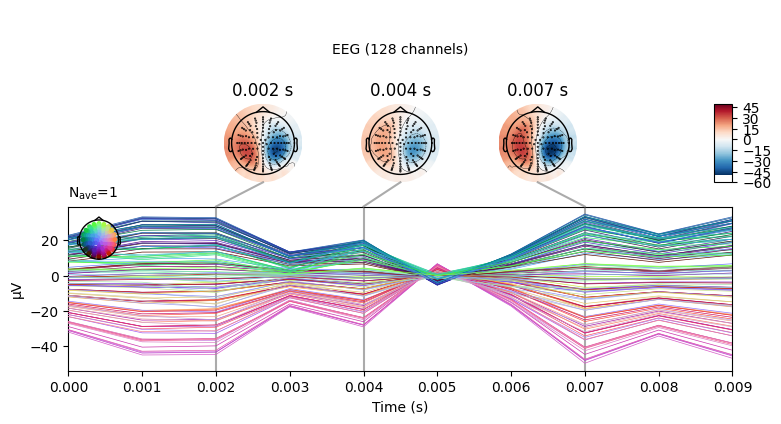

In [3]:
settings = dict(number_of_sources=3, extents=(1, 25), duration_of_trial=0.01, target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Solve

In [ ]:
from invert import Solver
solver = Solver("SSMP")
solver.make_inverse_operator(fwd, evoked)
stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info)
evoked_.plot_joint()

In [12]:
from invert import Solver
# from invert.config import all_solvers
from invert.evaluate import nmse, corr
from invert.adapters import contextualize_bd
import pickle as pkl

# if "LUCAS" in all_solvers:
#     all_solvers.remove("LUCAS")
# # if "Multiple Sparse Priors" in all_solvers:
# #     all_solvers.remove("Multiple Sparse Priors")
# if "Backus-Gilbert" in all_solvers:
#     all_solvers.remove("Backus-Gilbert")
# if "Fully-Connected" in all_solvers:
#     all_solvers.remove("Fully-Connected")

all_solvers = [ "SOMP", "SSMP", "MNE", "dSPM", "LORETA", "Bayesian Beamformer LORETA",]
settings = dict(number_of_sources=(1,15), extents=(1, 25), duration_of_trial=0.1, target_snr=1e99)
errors = {sname: [] for sname in all_solvers}
# solvers = dict()

for i in range(25):
    print(i)
    sim = Simulation(fwd, info, settings).simulate(2)
    stc = sim.source_data[0]
    evoked = sim.eeg_data[0].average()

    for solver_name in all_solvers:
        print(solver_name)
        solver = Solver(solver=solver_name)
        if (not solver_name in solvers):
            solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha="auto")
        stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
        # stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
        # error = np.mean(corr(stc.data, stc_hat.data))
        error = np.mean(corr(stc.data, stc_hat.data))
        
        errors[solver_name].append( error )
        
 
    print("Saving errors")
    fn = "errors.pkl"
    with open(fn, 'wb') as f:
        pkl.dump(errors, f)

0
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1982.65it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 46.51it/s]


SOMP
SSMP
MNE


c:\Users\lukas\Dokumente\projects\invert\dev\..\invert\solvers\base.py:109: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
LORETA
Bayesian Beamformer LORETA
Saving errors
1
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<?, ?it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 52.62it/s]


SOMP
SSMP
MNE


c:\Users\lukas\Dokumente\projects\invert\dev\..\invert\solvers\base.py:109: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
LORETA
Bayesian Beamformer LORETA
Saving errors
2
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1993.49it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 55.53it/s]


SOMP
SSMP
MNE
dSPM


c:\Users\lukas\Dokumente\projects\invert\dev\..\invert\solvers\base.py:109: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


LORETA
Bayesian Beamformer LORETA
Saving errors
3
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<?, ?it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 54.02it/s]


SOMP
SSMP
MNE


c:\Users\lukas\Dokumente\projects\invert\dev\..\invert\solvers\base.py:109: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
LORETA
Bayesian Beamformer LORETA
Saving errors
4
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1996.34it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 56.62it/s]


SOMP
SSMP
MNE


c:\Users\lukas\Dokumente\projects\invert\dev\..\invert\solvers\base.py:109: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
LORETA
Bayesian Beamformer LORETA
Saving errors
5
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1993.96it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 55.54it/s]


SOMP
SSMP
MNE


c:\Users\lukas\Dokumente\projects\invert\dev\..\invert\solvers\base.py:109: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
LORETA
Bayesian Beamformer LORETA
Saving errors
6
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1989.24it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 43.48it/s]


SOMP
SSMP
MNE
dSPM


c:\Users\lukas\Dokumente\projects\invert\dev\..\invert\solvers\base.py:109: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


LORETA
Bayesian Beamformer LORETA
Saving errors
7
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1984.06it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 54.05it/s]


SOMP
SSMP
MNE


c:\Users\lukas\Dokumente\projects\invert\dev\..\invert\solvers\base.py:109: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
LORETA
Bayesian Beamformer LORETA
Saving errors
8
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 2002.05it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 55.55it/s]


SOMP
SSMP
MNE


c:\Users\lukas\Dokumente\projects\invert\dev\..\invert\solvers\base.py:109: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
LORETA
Bayesian Beamformer LORETA
Saving errors
9
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1993.02it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 47.30it/s]


SOMP
SSMP
MNE


c:\Users\lukas\Dokumente\projects\invert\dev\..\invert\solvers\base.py:109: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
LORETA
Bayesian Beamformer LORETA
Saving errors
10
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<?, ?it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 52.61it/s]


SOMP


In [11]:
from invert import Solver
from invert.config import all_solvers
from invert.evaluate import corr

if "LUCAS" in all_solvers:
    all_solvers.remove("LUCAS")
# if "Multiple Sparse Priors" in all_solvers:
#     all_solvers.remove("Multiple Sparse Priors")
if "Backus-Gilbert" in all_solvers:
    all_solvers.remove("Backus-Gilbert")
if "Fully-Connected" in all_solvers:
    all_solvers.remove("Fully-Connected")
    
settings = dict(number_of_sources=(1,10), extents=(1, 25), duration_of_trial=1, target_snr=(1,25))
errors = {sname: [] for sname in all_solvers}
# solvers = dict()

for solver_name in all_solvers:
    print(solver_name)
    solver = Solver(solver=solver_name)
    solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha="auto")
    stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
    stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
    # error = np.mean(corr(stc.data, stc_hat.data))
    error = np.mean(corr(abs(stc.data), abs(stc_hat.data)))
    
    errors[solver_name].append( error )

MNE
Using control points [4.17998781e-10 6.02943763e-10 3.61240362e-09]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


ValueError: list.remove(x): x not in list

In [ ]:
import pickle as pkl
fn = "errors.pkl"
with open(fn, 'rb') as f:
    errors = pkl.load(f)

In [9]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=0.8)
df = pd.DataFrame(errors)
sorted_index = df.median().sort_values().index
df = df[sorted_index]

plt.figure()
sns.boxplot(data=df)
plt.title("Correlation with ground truth")


df_mean_var = pd.concat([df.mean(), df.std()], axis=1)
df_mean_var = df_mean_var.rename(columns={0: "Median", 1: "Variance"})
df_mean_var["MedVar"] = df_mean_var["Median"] / df_mean_var["Variance"]
df_mean_var["Method"] = df_mean_var.index
display(df_mean_var)

plt.figure()
sns.scatterplot(x="Median", y="Variance", hue="Method", size="MedVar", data=df_mean_var)
plt.xlabel("Median")
plt.ylabel("Variance")


,Median,Variance,MedVar,Method
SSMP,0.288852,0.383166,0.753857,SSMP
dSPM,0.128891,0.044049,2.926098,dSPM
SOMP,0.342302,0.389448,0.878940,SOMP
LORETA,0.188914,0.146683,1.287911,LORETA
MNE,0.255611,0.118851,2.150689,MNE
Bayesian Beamformer LORETA,0.278552,0.221562,1.257221,Bayesian Beamformer LORETA


Text(0, 0.5, 'Variance')

In [10]:
df

,SSMP,dSPM,SOMP,LORETA,MNE,Bayesian Beamformer LORETA
0,-0.002383,0.194089,-0.002419,0.376742,0.224364,NaN
1,0.379513,0.091561,0.694136,0.134004,0.283559,0.026753
2,0.165132,0.199463,0.071205,0.508050,0.404598,0.584646
3,0.115600,0.183268,0.105150,0.388614,0.413624,0.325212
4,0.000703,0.120260,0.732994,-0.003283,0.099231,0.071327
5,0.234657,0.096962,-0.001434,0.178747,0.311410,0.030994
6,0.000077,0.155533,0.020301,0.231564,0.300801,0.282387
7,1.000000,0.104862,1.000000,0.072218,0.074430,0.062349
8,1.000000,0.088204,1.000000,0.063246,0.061415,0.260000
9,1.000000,0.107112,1.000000,-0.005841,0.196408,0.088528


In [ ]:
settings = dict(number_of_sources=3, extents=(25, 35), duration_of_trial=0.025, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

In [ ]:
# from invert.solvers.empirical_bayes import SolverChampagne
# from invert.solvers.esinet import SolverFullyConnected
# solver_fc = SolverFullyConnected().make_inverse_operator(fwd, evoked)
# solver_ch = SolverChampagne().make_inverse_operator(fwd, evoked)
from invert.evaluate import nmse, corr

stc_hat = solver_ch.apply_inverse_operator(evoked)
stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, "Champagne", 'title',
#                font_size=14)
error_ch = np.mean(corr(abs(stc.data), abs(stc_hat.data)))

stc_hat = solver_fc.apply_inverse_operator(evoked)
stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, "Fully-Connected", 'title',
#                font_size=14)
error_fc = np.mean(corr(abs(stc.data), abs(stc_hat.data)))

print(f"Champ: {error_ch}\nFC: {error_fc}")